In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, DataLoader,TensorDataset
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## 1.Data Preprocessing

In [67]:
# Load the data
data = pd.read_csv('/kaggle/input/jena-climate-2009-2016/jena_climate_2009_2016.csv')
data['Date Time'] = pd.to_datetime(data['Date Time'], dayfirst=True)
data.set_index('Date Time', inplace=True)
data.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [68]:
print(data.isnull().sum())

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64


In [69]:
target = data['T (degC)']
features = data.drop(columns=['T (degC)'],axis=1)

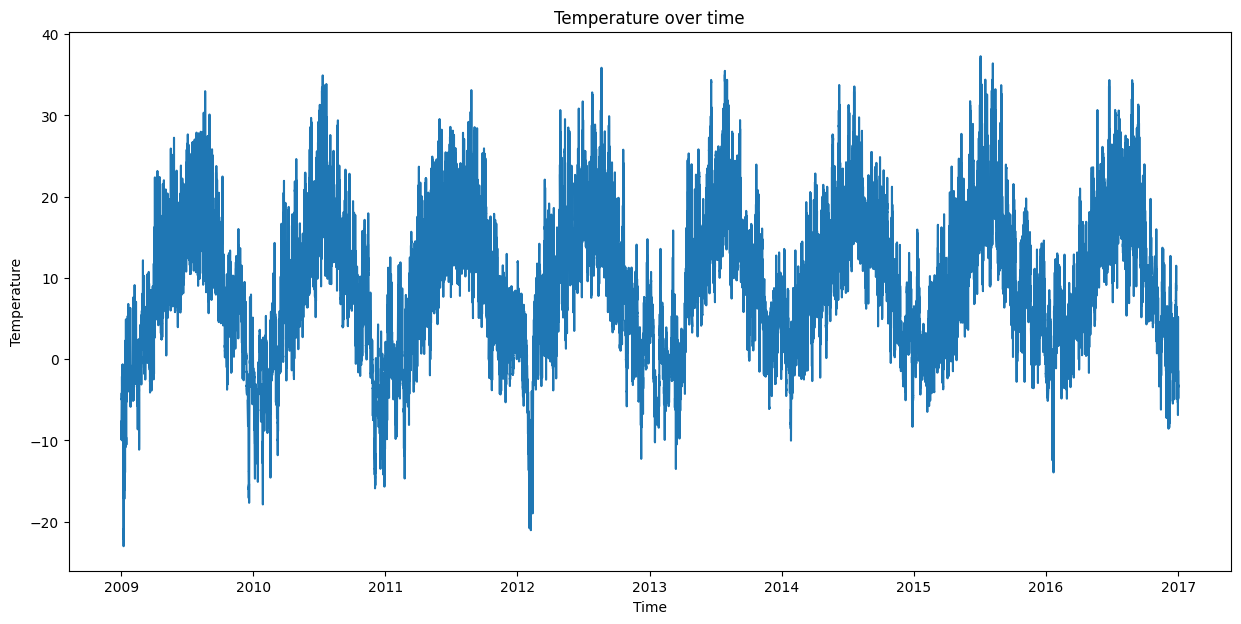

In [70]:
# Plot the data
plt.figure(figsize=(15, 7))
plt.plot(target)
plt.title('Temperature over time')
plt.ylabel('Temperature')
plt.xlabel('Time')
plt.show()

In [71]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_data = pd.DataFrame(scaled_features, columns=features.columns)
scaled_data['T (degC)'] = target.values
scaled_data.head()

,p (mbar),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),T (degC)
0,0.814939,0.243662,0.334788,0.923033,0.037886,0.084272,0.004782,0.081679,0.082798,0.743213,0.997262,0.997830,0.423056,-8.02
1,0.815430,0.237241,0.326891,0.924182,0.036294,0.081003,0.004564,0.078843,0.079586,0.749349,0.997231,0.997805,0.378056,-8.41
2,0.815037,0.235594,0.326268,0.929925,0.035976,0.080639,0.004347,0.078276,0.079229,0.750666,0.997178,0.997718,0.476667,-8.51
3,0.814840,0.239052,0.331255,0.933372,0.036772,0.082819,0.004130,0.080545,0.081370,0.747523,0.997193,0.997705,0.550000,-8.31
4,0.814840,0.239546,0.331879,0.932223,0.036931,0.083182,0.004130,0.080545,0.081727,0.746954,0.997191,0.997718,0.595278,-8.27


In [72]:
# Determine sizes for each set
train_size = int(len(scaled_data) * 0.7)
val_size = int(len(scaled_data) * 0.15)
# Split data
train_data = scaled_data[:train_size]
val_data = scaled_data[train_size:train_size + val_size]
test_data = scaled_data[train_size + val_size:]
print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)

Training data shape: (294385, 14)
Validation data shape: (63082, 14)
Test data shape: (63084, 14)


## 2. Model Architecture

In [73]:
class TimeSeriesModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(TimeSeriesModel, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = lstm_out[:, -1, :]
        out = self.fc(out)
        return out


In [126]:
input_size = len(features.columns) 
hidden_size = 64  
num_layers = 2   
output_size = 1 
seq_length = 5
batch_size = 64
epochs = 10


In [128]:
model = TimeSeriesModel(input_size, hidden_size, num_layers, output_size)
model.to(device)
print(model)

TimeSeriesModel(
  (lstm): LSTM(13, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [129]:
# Define loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [112]:
def create_sequences(data, seq_length, target_column='T (degC)'):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequence = data.iloc[i:i+seq_length].drop(columns=[target_column]).values
        target = data.iloc[i + seq_length][target_column]
        sequences.append(sequence)
        targets.append(target)
    return torch.tensor(np.array(sequences), dtype=torch.float32), torch.tensor(np.array(targets), dtype=torch.float32)

In [113]:
train_sequences, train_targets = create_sequences(train_data, seq_length)
val_sequences, val_targets = create_sequences(val_data, seq_length)
test_sequences, test_targets = create_sequences(test_data, seq_length)

In [124]:
# Create TensorDataset
train_dataset = TensorDataset(train_sequences, train_targets)
val_dataset = TensorDataset(val_sequences, val_targets)
test_dataset = TensorDataset(test_sequences, test_targets)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [115]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=1):
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for batch_sequences, batch_targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", leave=False):
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs.squeeze(), batch_targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for val_sequences, val_targets in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", leave=False):
                val_sequences, val_targets = val_sequences.to(device), val_targets.to(device)
                val_outputs = model(val_sequences)
                batch_val_loss = criterion(val_outputs.squeeze(), val_targets)
                val_loss += batch_val_loss.item()
        avg_val_loss = val_loss / len(val_loader)
        rmse_val_loss = avg_val_loss ** 0.5
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss (MSE): {avg_train_loss:.4f}, Validation Loss (MSE): {avg_val_loss:.4f}, Validation Loss (RMSE): {rmse_val_loss:.4f}')

## 3. Training and Evaluation

In [130]:
# Train the model
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=epochs)

Epoch [1/10], Training Loss (MSE): 39.8546, Validation Loss (MSE): 0.2213, Validation Loss (RMSE): 0.4704


Epoch [2/10], Training Loss (MSE): 0.0919, Validation Loss (MSE): 0.1074, Validation Loss (RMSE): 0.3277


Epoch [3/10], Training Loss (MSE): 0.0643, Validation Loss (MSE): 0.0502, Validation Loss (RMSE): 0.2240


Epoch [4/10], Training Loss (MSE): 0.0597, Validation Loss (MSE): 0.0540, Validation Loss (RMSE): 0.2324


Epoch [5/10], Training Loss (MSE): 0.0567, Validation Loss (MSE): 0.0644, Validation Loss (RMSE): 0.2538


Epoch [6/10], Training Loss (MSE): 0.0544, Validation Loss (MSE): 0.0481, Validation Loss (RMSE): 0.2193


Epoch [7/10], Training Loss (MSE): 0.0525, Validation Loss (MSE): 0.0601, Validation Loss (RMSE): 0.2452


Epoch [8/10], Training Loss (MSE): 0.0521, Validation Loss (MSE): 0.0481, Validation Loss (RMSE): 0.2192


Epoch [9/10], Training Loss (MSE): 0.0513, Validation Loss (MSE): 0.0447, Validation Loss (RMSE): 0.2115


Epoch [10/10], Training Loss (MSE): 0.0504, Validation Loss (MSE): 0.0591, Validation Loss (RMSE): 0.2432


In [131]:
def evaluate_model(model, criterion, test_loader):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for test_sequences, test_targets in test_loader:
            test_sequences, test_targets = test_sequences.to(device), test_targets.to(device)
            test_outputs = model(test_sequences)
            batch_test_loss = criterion(test_outputs.squeeze(), test_targets)
            test_loss += batch_test_loss.item()
    avg_test_loss = test_loss / len(test_loader)
    rmse_test_loss = avg_test_loss ** 0.5
    print(f'Final Test Loss (MSE): {avg_test_loss:.4f}, Final Test Loss (RMSE): {rmse_test_loss:.4f}')

In [132]:
# Evaluate the model
evaluate_model(model, criterion, test_loader)

Final Test Loss (MSE): 0.0534, Final Test Loss (RMSE): 0.2311


With a final test MSE of 0.0534 and RMSE of 0.2311, the model's predictions would have an average error of approximately **±0.2°C** Ex: if the true temperature were 10°C i may be in rnage of [9.8°C-10.2°C]

In [133]:
def generate_predictions(model, data_loader, device):
    model.eval()  
    predictions = []
    actuals = []
    with torch.no_grad():
        for sequences, targets in data_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            # Generate predictions
            outputs = model(sequences)
            # Store predictions and actuals
            predictions.extend(outputs.squeeze().cpu().numpy())
            actuals.extend(targets.cpu().numpy())
    return predictions, actuals


def plot_predictions(actuals, predictions, title="Actual vs Predicted Values"):
    plt.figure(figsize=(14, 7))
    plt.plot(actuals, label="Actual Data", color="blue")
    plt.plot(predictions, label="Predicted Data", color="red", alpha=0.5)
    plt.xlabel("Time Steps")
    plt.ylabel("Temperature")
    plt.title(title)
    plt.legend()
    plt.show()

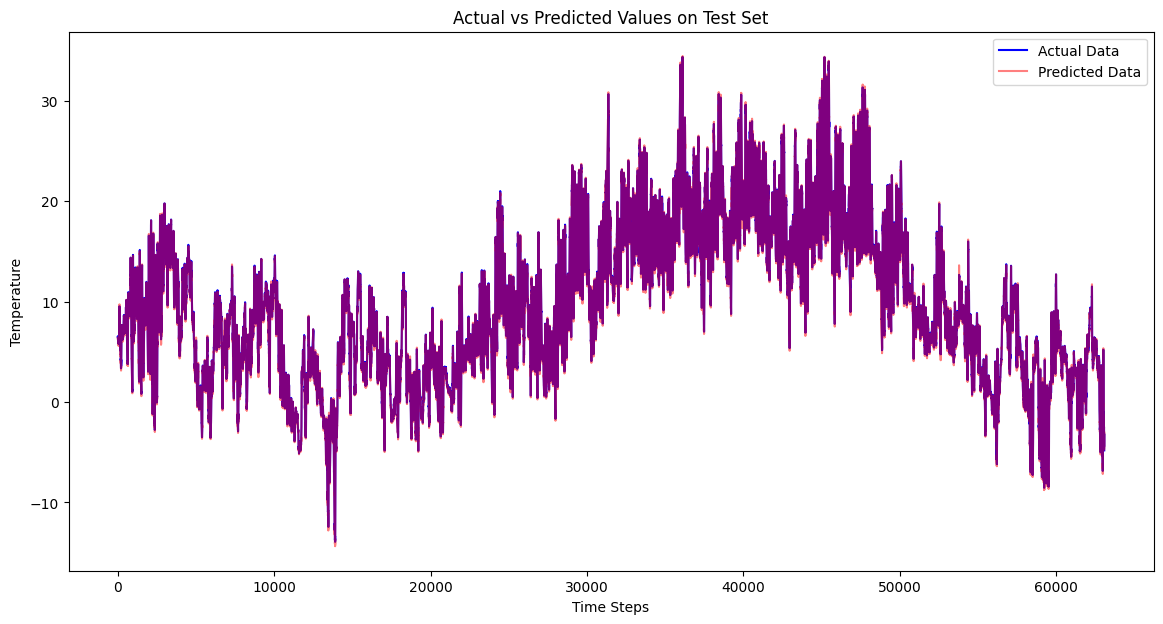

In [134]:
predictions, actuals = generate_predictions(model, test_loader, device)
plot_predictions(actuals, predictions, title="Actual vs Predicted Values on Test Set")

The plot shows the actual vs. predicted temperature values on the test set, with the predictions closely following the actual data trend. The overlap between the blue (actual) and red (predicted) lines suggests that the model performs well in capturing temperature variations over time. Minor discrepancies may be observed, but overall, the predictions align well with the actual values, indicating good model accuracy

In [162]:
def objective(trial):

    lr = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [ 32, 64.128])
    num_layers = trial.suggest_int('num_layers', 2, 6, step=1)
    hidden_size = trial.suggest_categorical('hidden_size', [32, 64])
    model = TimeSeriesModel(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=1).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=int(batch_size), shuffle=False)

    for _ in range(5):  # Fewer epochs for tuning
        model.train()
        for batch_sequences, batch_targets in train_loader:
            batch_sequences, batch_targets = batch_sequences.to(device), batch_targets.to(device)
            optimizer.zero_grad()
            outputs = model(batch_sequences)
            loss = criterion(outputs.squeeze(), batch_targets)
            loss.backward()
            optimizer.step()

    # Validation 

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_sequences, val_targets in val_loader:
            val_sequences, val_targets = val_sequences.to(device), val_targets.to(device)
            val_outputs = model(val_sequences)
            batch_val_loss = criterion(val_outputs.squeeze(), val_targets)
            val_loss += batch_val_loss.item()
    avg_val_loss = val_loss / len(val_loader)

    return avg_val_loss

In [163]:
def run_hyperparameter_optimization(n_trials=1):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)
    print("Best Hyperparameters:")
    print(study.best_params)
    print(f"Best Validation Loss: {study.best_value:.4f}")
    return study.best_params

In [164]:
# Run hyperparameter optimization
best_params = run_hyperparameter_optimization(n_trials=5)

[I 2024-11-07 21:47:18,265] A new study created in memory with name: no-name-ffbd8536-a894-4395-87d5-88840da00e9d
[I 2024-11-07 21:48:49,676] Trial 0 finished with value: 0.08988493388315849 and parameters: {'lr': 0.0041197432228919015, 'batch_size': 32, 'num_layers': 6, 'hidden_size': 64}. Best is trial 0 with value: 0.08988493388315849.
[I 2024-11-07 21:50:03,804] Trial 1 finished with value: 0.07713986788196281 and parameters: {'lr': 0.0011039668693052416, 'batch_size': 32, 'num_layers': 4, 'hidden_size': 64}. Best is trial 1 with value: 0.07713986788196281.
[I 2024-11-07 21:50:34,133] Trial 2 finished with value: 0.04946804094348154 and parameters: {'lr': 0.003130150715375829, 'batch_size': 64.128, 'num_layers': 2, 'hidden_size': 32}. Best is trial 2 with value: 0.04946804094348154.
[I 2024-11-07 21:51:13,583] Trial 3 finished with value: 0.07143209128881216 and parameters: {'lr': 0.004946114761904362, 'batch_size': 64.128, 'num_layers': 4, 'hidden_size': 32}. Best is trial 2 with 

Best Hyperparameters:
{'lr': 0.003130150715375829, 'batch_size': 64.128, 'num_layers': 2, 'hidden_size': 32}
Best Validation Loss: 0.0495


In [165]:
model_best_params = TimeSeriesModel(input_size, best_params['hidden_size'], best_params['num_layers'], output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_best_params.parameters(), lr=best_params['lr'])
train_model(model_best_params, criterion, optimizer, train_loader, val_loader, epochs=epochs)

Epoch [1/10], Training Loss (MSE): 13.2316, Validation Loss (MSE): 0.1370, Validation Loss (RMSE): 0.3701


Epoch [2/10], Training Loss (MSE): 0.0743, Validation Loss (MSE): 0.0622, Validation Loss (RMSE): 0.2493


Epoch [3/10], Training Loss (MSE): 0.0580, Validation Loss (MSE): 0.0529, Validation Loss (RMSE): 0.2299


Epoch [4/10], Training Loss (MSE): 0.0549, Validation Loss (MSE): 0.0490, Validation Loss (RMSE): 0.2213


Epoch [5/10], Training Loss (MSE): 0.0529, Validation Loss (MSE): 0.0479, Validation Loss (RMSE): 0.2189


Epoch [6/10], Training Loss (MSE): 0.0505, Validation Loss (MSE): 0.0491, Validation Loss (RMSE): 0.2217


Epoch [7/10], Training Loss (MSE): 0.0505, Validation Loss (MSE): 0.0482, Validation Loss (RMSE): 0.2195


Epoch [8/10], Training Loss (MSE): 0.0498, Validation Loss (MSE): 0.0466, Validation Loss (RMSE): 0.2159


Epoch [9/10], Training Loss (MSE): 0.0497, Validation Loss (MSE): 0.0466, Validation Loss (RMSE): 0.2159


Epoch [10/10], Training Loss (MSE): 0.0484, Validation Loss (MSE): 0.0510, Validation Loss (RMSE): 0.2258


In [166]:
evaluate_model(model_best_params, criterion, test_loader)

Final Test Loss (MSE): 0.0459, Final Test Loss (RMSE): 0.2143


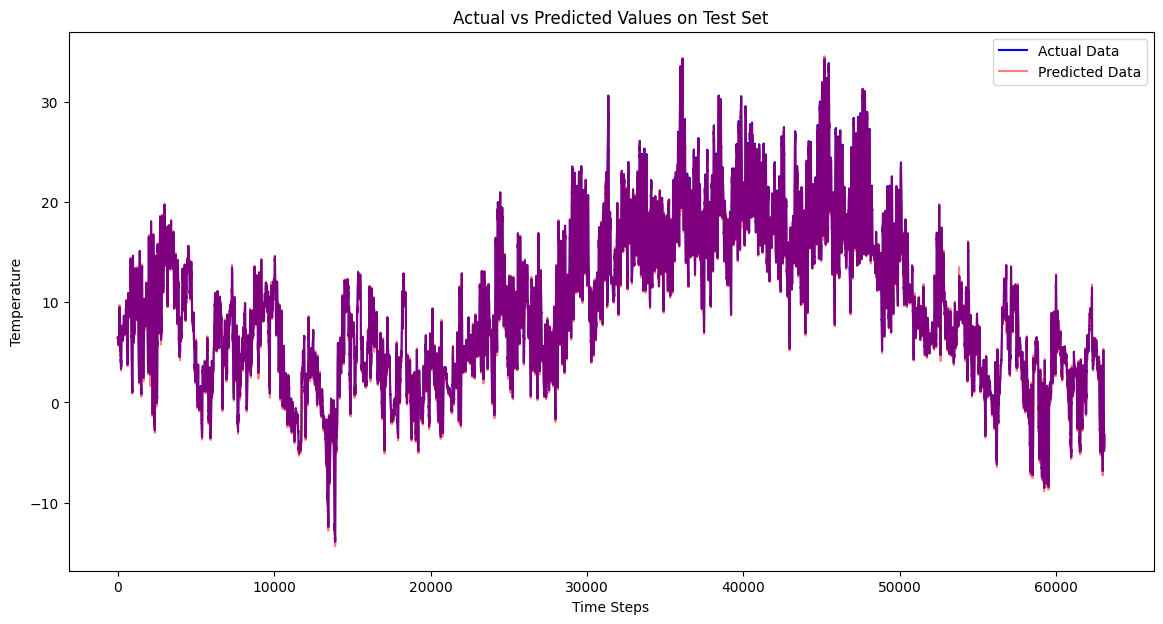

In [167]:
predictions, actuals = generate_predictions(model_best_params, test_loader, device)
plot_predictions(actuals, predictions, title="Actual vs Predicted Values on Test Set")